# CHAPTER 8 딥러닝을 이용한 투자 전략
## 8.2 RNN을 활용한 주가 방향성 분류 예측
* 순환신경망(RNN)
    * Recurrent Neural Network
    * ![RNN](../images/rnn.png)
    * RNN 계층의 계산 그래프
        * ![RNN 내부](../images/rnn2.png)
    * 문제점
        * 기울기 소실 / 기울기 폭발
            * ![tanh](../images/tanh.png)
* LSTM
    * Long Short-Term Memory
    * ![RNN vs LSTM](../images/RnnVsLstm.png)
    * 게이트란?
        * ![gate](../images/gate.png)
    * output 게이트
        * ![output 게이트](../images/output.png)
    * forget 게이트
        * ![forget 게이트](../images/forget.png)
    * 새로운 기억셀
        * ![새로운 기억셀](../images/memory.png)
    * input 게이트
        * ![input 게이트](../images/input.png)
* Application of Deep Learning to Algorithmic Trading
    * https://cs229.stanford.edu/proj2017/final-reports/5241098.pdf
    * ![모델링](../images/modelAndFactor.PNG)

### 8.2.1 데이터

In [1]:
import pandas as pd
import FinanceDataReader as fdr

intc_df = fdr.DataReader('INTC', start='2000-01-01')
sox_df = fdr.DataReader('^SOX', start='2000-01-01')
vix_df = fdr.DataReader('VIX', start='2000-01-01')
snp500_df = fdr.DataReader('SPY', start='2000-01-01')

intc_df.to_csv('data/intc.csv')
sox_df.to_csv('data/sox_df.csv')
vix_df.to_csv('data/vix_df.csv')
snp500_df.to_csv('data/snp500_df.csv')

In [2]:
import pandas as pd
import pandas_datareader as pdr
import talib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler

In [3]:
# data Load
df = pd.read_csv('data/intc.csv',
                 index_col='Date',
                 parse_dates=True)
sox_df = pd.read_csv('data/sox_df.csv',
                     index_col='Date',
                     parse_dates=True)
vix_df = pd.read_csv('data/vix_df.csv',
                     index_col='Date',
                     parse_dates=True)
snp500_df = pd.read_csv('data/snp500_df.csv',
                        index_col='Date',
                        parse_dates=True)

In [4]:
df['next_price'] = df['Adj Close'].shift(-1)
df['next_rtn'] = df['Close'] / df['Open'] -1
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#1.RA : Standard deviation rolling average
# Moving Average
df['MA5'] = talib.SMA(df['Close'],timeperiod=5)
df['MA10'] = talib.SMA(df['Close'],timeperiod=10)
df['RASD5'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=5)
df['RASD10'] = talib.SMA(talib.STDDEV(df['Close'], timeperiod=5, nbdev=1),timeperiod=10)

#2.MACD : Moving Average Convergence/Divergence
macd, macdsignal, macdhist = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD'] = macd

# Momentum Indicators
#3.CCI : Commodity Channel Index
df['CCI'] = talib.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
# Volatility Indicators

#4.ATR : Average True Range
df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

#5.BOLL : Bollinger Band
upper, middle, lower = talib.BBANDS(df['Close'],timeperiod=20,nbdevup=2,nbdevdn=2,matype=0)
df['ub'] = upper
df['middle'] = middle
df['lb'] = lower

#7.MTM1
df['MTM1'] = talib.MOM(df['Close'], timeperiod=1)

#7.MTM3
df['MTM3'] = talib.MOM(df['Close'], timeperiod=3)

#8.ROC : Rate of change : ((price/prevPrice)-1)*100
df['ROC'] = talib.ROC(df['Close'], timeperiod=60)

#9.WPR : william percent range (Williams' %R)
df['WPR'] = talib.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [5]:
snp500_df = snp500_df.loc[:,['Close']].copy()
snp500_df.rename(columns={'Close':'S&P500'},inplace=True)
sox_df = sox_df.loc[:,['Close']].copy()
sox_df.rename(columns={'Close':'SOX'},inplace=True)
vix_df = vix_df.loc[:,['Close']].copy()
vix_df.rename(columns={'Close':'VIX'},inplace=True)

df = df.join(snp500_df,how='left')
df = df.join(sox_df,how='left')
df = df.join(vix_df,how='left')

In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,next_price,next_rtn,log_return,CCI,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,41.632813,43.6875,41.62500,43.50000,25.214333,57710200,24.036930,0.044849,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.4375,713.200012,24.209999
2000-01-04,42.718750,43.9375,41.12500,41.46875,24.036930,51019600,24.236187,-0.029261,-0.047821,NaN,...,NaN,NaN,NaN,-2.03125,NaN,NaN,NaN,139.7500,687.320007,27.010000
2000-01-05,41.500000,42.9375,40.25000,41.81250,24.236187,52389000,22.823322,0.007530,0.008255,NaN,...,NaN,NaN,NaN,0.34375,NaN,NaN,NaN,140.0000,678.539978,26.410000
2000-01-06,40.875000,41.6875,39.09375,39.37500,22.823322,55171200,23.765234,-0.036697,-0.060064,NaN,...,NaN,NaN,NaN,-2.43750,-4.12500,NaN,NaN,137.7500,669.330017,25.730000
2000-01-07,38.750000,41.0000,38.68750,41.00000,23.765234,41096400,24.852043,0.058065,0.040441,NaN,...,NaN,NaN,NaN,1.62500,-0.46875,NaN,NaN,145.7500,690.750000,21.719999


In [7]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,next_price,next_rtn,log_return,CCI,...,ub,middle,lb,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-10,31.870001,32.830002,31.770000,32.740002,32.740002,36305700,33.299999,0.027298,0.027560,-71.734656,...,36.088383,33.4875,30.886616,0.890002,0.230004,2.248601,-76.265226,439.660004,3651.600098,15.07
2023-07-11,32.820000,33.360001,32.500000,33.299999,33.299999,28148800,33.980000,0.014625,0.016960,9.309891,...,35.996072,33.5855,31.174927,0.559997,1.330000,3.641450,-47.683924,442.459991,3653.530029,14.84
2023-07-12,33.689999,34.080002,33.060001,33.980000,33.980000,37762200,33.869999,0.008608,0.020215,95.933573,...,36.035279,33.6310,31.226721,0.680001,2.130000,6.553782,-8.771927,446.019989,3721.469971,13.54
2023-07-13,34.150002,34.299999,33.619999,33.869999,33.869999,32745800,33.150002,-0.008199,-0.003242,106.183815,...,36.032413,33.6290,31.225586,-0.110001,1.129997,5.382701,-14.726027,449.559998,3797.129883,13.61
2023-07-14,33.779999,33.869999,33.000000,33.150002,33.150002,29793344,NaN,-0.018650,-0.021487,28.008482,...,35.744005,33.5075,31.270995,-0.719997,-0.149997,4.147037,-39.383459,449.279999,3750.413818,13.34


In [8]:
# feature list
# feature_list = ['Adj Close', 'log_return', 'CCI','next_price']
# 볼린저 밴드와 MACD를 어떻게 활용해야할까? 음. 아님 그냥 그대로 사용하는 건가?
feature1_list = ['Open','High','Low','Adj Close','Volume','log_return']
feature2_list = ['RASD5','RASD10','ub','lb','CCI','ATR','MACD','MA5','MA10','MTM1','MTM3','ROC','WPR']
feature3_list = ['S&P500', 'SOX', 'VIX']
# feature4_list = ['next_price']
feature4_list = ['next_rtn']

all_features = feature1_list + feature2_list + feature3_list + feature4_list

In [9]:
phase_flag = '5'

if phase_flag == '1' :
    train_from = '2010-01-04'
    train_to = '2012-01-01'

    val_from = '2012-01-01'
    val_to = '2012-04-01'

    test_from = '2012-04-01'
    test_to = '2012-07-01'

elif phase_flag == '2' :
    train_from = '2012-07-01'
    train_to = '2014-07-01'

    val_from = '2014-07-01'
    val_to = '2014-10-01'

    test_from = '2014-10-01'
    test_to = '2015-01-01'

elif phase_flag == '3' :
    train_from = '2015-01-01'
    train_to = '2017-07-01'

    val_from = '2017-07-01'
    val_to = '2017-10-01'

    test_from = '2017-10-01'
    test_to = '2018-01-01'

elif phase_flag == '4' :
    train_from = '2018-01-01'
    train_to = '2020-07-01'

    val_from = '2020-07-01'
    val_to = '2020-10-01'

    test_from = '2020-10-01'
    test_to = '2021-01-01'

else:
    train_from = '2021-01-01'
    train_to = '2023-01-01'

    val_from = '2023-01-01'
    val_to = '2023-04-01'

    test_from = '2023-04-01'
    test_to = '2023-07-01'

In [10]:
# train / validation / testing
train_df  = df.loc[train_from:train_to,all_features].copy()
val_df = df.loc[val_from:val_to,all_features].copy()
test_df   = df.loc[test_from:test_to,all_features].copy()

In [11]:
train_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MA5,MA10,MTM1,MTM3,ROC,WPR,S&P500,SOX,VIX,next_rtn
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,49.889999,51.389999,49.400002,45.818188,46102500,-0.003015,0.948198,1.227412,52.668346,45.749653,...,48.939999,47.832999,-0.150002,0.279999,-5.695842,-28.778165,368.790009,2783.209961,26.969999,-0.004410
2021-01-05,49.450001,50.830002,49.330002,46.685299,24866600,0.018748,0.995731,1.155439,52.425392,45.854608,...,49.648000,48.148000,0.940003,1.860001,-5.171441,-13.665569,371.329987,2837.169922,25.340000,0.023458
2021-01-06,50.439999,52.150002,50.200001,47.137295,36809600,0.009635,0.933832,1.041412,52.550902,45.819097,...,49.989999,48.621999,0.489997,1.279998,-3.256346,-15.195427,373.549988,2827.959961,25.070000,0.013085
2021-01-07,51.490002,52.689999,51.299999,48.142769,32092300,0.021106,0.898418,0.921315,52.818061,45.701938,...,50.677999,49.223999,1.090001,2.520001,-3.136604,-6.711412,379.100006,2937.000000,22.370001,0.013595
2021-01-08,52.450001,52.529999,51.270000,47.644646,34625400,-0.010401,0.841117,0.841655,53.033054,45.644945,...,51.044000,49.732000,-0.539997,1.040001,-4.049786,-13.959697,381.260010,2936.469971,21.559999,-0.015253


In [12]:
def min_max_normal(tmp_df):
    eng_list = []
    sample_df = tmp_df.copy()
    for x in all_features:
        if x in feature4_list :
            continue
        series = sample_df[x].copy()
        values = series.values
        values = values.reshape((len(values), 1))
        # train the normalization
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaler = scaler.fit(values)
#         print('columns : %s , Min: %f, Max: %f' % (x, scaler.data_min_, scaler.data_max_))
        # normalize the dataset and print
        normalized = scaler.transform(values)
        new_feature = '{}_normal'.format(x)
        eng_list.append(new_feature)
        sample_df[new_feature] = normalized
    return sample_df, eng_list

In [13]:
train_sample_df, eng_list =  min_max_normal(train_df)
val_sample_df, eng_list =  min_max_normal(val_df)
test_sample_df, eng_list = min_max_normal(test_df)

In [14]:
train_sample_df.head()

,Open,High,Low,Adj Close,Volume,log_return,RASD5,RASD10,ub,lb,...,MACD_normal,MA5_normal,MA10_normal,MTM1_normal,MTM3_normal,ROC_normal,WPR_normal,S&P500_normal,SOX_normal,VIX_normal
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,49.889999,51.389999,49.400002,45.818188,46102500,-0.003015,0.948198,1.227412,52.668346,45.749653,...,0.456109,0.568050,0.550492,0.618586,0.518471,0.395675,0.714351,0.100949,0.330755,0.538739
2021-01-05,49.450001,50.830002,49.330002,46.685299,24866600,0.018748,0.995731,1.155439,52.425392,45.854608,...,0.484033,0.585239,0.558362,0.724105,0.620869,0.402298,0.865930,0.121915,0.359500,0.465315
2021-01-06,50.439999,52.150002,50.200001,47.137295,36809600,0.009635,0.933832,1.041412,52.550902,45.819097,...,0.512960,0.593542,0.570204,0.680542,0.583279,0.426488,0.850585,0.140239,0.354594,0.453153
2021-01-07,51.490002,52.689999,51.299999,48.142769,32092300,0.021106,0.898418,0.921315,52.818061,45.701938,...,0.551643,0.610245,0.585245,0.738625,0.663642,0.428000,0.935680,0.186050,0.412681,0.331532
2021-01-08,52.450001,52.529999,51.270000,47.644646,34625400,-0.010401,0.841117,0.841655,53.033054,45.644945,...,0.572270,0.619131,0.597936,0.580833,0.567725,0.416466,0.862980,0.203880,0.412398,0.295045


In [15]:
num_step = 5
num_unit = 200

In [16]:
def create_dateset_binary(data, feature_list, step, n):
    '''
    다음날 시종가 수익률 라벨링.
    '''
    train_xdata = np.array(data[feature_list[0:n]])

    # 가장 뒤 n step을 제외하기 위해. 왜냐하면 학습 input으로는 어차피 10개만 주려고 하니깐.
    m = np.arange(len(train_xdata) - step)
    #     np.random.shuffle(m)  # shufflee은 빼자.
    x, y = [], []
    for i in m:
        a = train_xdata[i:(i+step)]
        x.append(a)
    x_batch = np.reshape(np.array(x), (len(m), step, n))

    train_ydata = np.array(data[[feature_list[n]]])
    # n_step 이상부터 답을 사용할 수 있는거니깐.
    for i in m + step :
        next_rtn = train_ydata[i][0]
        if next_rtn > 0 :
            label = 1
        else :
            label = 0
        y.append(label)
    y_batch = np.reshape(np.array(y), (-1,1))
    return x_batch, y_batch

In [17]:
eng_list = eng_list + feature4_list
n_feature = len(eng_list)-1
# LSTM할때 사용했던 소스코드.
x_train, y_train = create_dateset_binary(train_sample_df[eng_list], eng_list, num_step, n_feature)
x_val, y_val = create_dateset_binary(val_sample_df[eng_list], eng_list, num_step, n_feature)
x_test, y_test = create_dateset_binary(test_sample_df[eng_list], eng_list, num_step, n_feature)

In [18]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [19]:
print(pd.DataFrame(y_train).sum())
print(pd.DataFrame(y_val).sum())
print(pd.DataFrame(y_test).sum())

0    265.0
1    233.0
dtype: float32
0    22.0
1    35.0
dtype: float32
0    29.0
1    28.0
dtype: float32


### 8.2.2 모델 구조

In [20]:
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, LSTM
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout
from keras import backend as K
from keras import regularizers

In [21]:
# LSTM 모델을 생성한다.
K.clear_session()
input_layer = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
layer_lstm_1 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(input_layer)
layer_lstm_1 = BatchNormalization()(layer_lstm_1)
layer_lstm_2 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_1)
layer_lstm_2 = Dropout(0.25)(layer_lstm_2)
layer_lstm_3 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_2)
layer_lstm_3 = BatchNormalization()(layer_lstm_3)
layer_lstm_4 = LSTM(num_unit, return_sequences = True, recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_3)
layer_lstm_4 = Dropout(0.25)(layer_lstm_4)
layer_lstm_5 = LSTM(num_unit , recurrent_regularizer = regularizers.l2(0.01))(layer_lstm_4)
layer_lstm_5 = BatchNormalization()(layer_lstm_5)
output_layer = Dense(2, activation='sigmoid')(layer_lstm_5)

model = Model(input_layer, output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [22]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 22)]           0         
                                                                 
 lstm (LSTM)                 (None, 5, 200)            178400    
                                                                 
 batch_normalization (Batch  (None, 5, 200)            800       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout (Dropout)           (None, 5, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 200)            320800    
                                                             

### 8.2.3 모델 학습

In [23]:
history = model.fit(x_train,y_train,epochs=20, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/20
50/50 [==============================] - 61s 270ms/step - loss: 6.3478 - accuracy: 0.5141 - val_loss: 3.0721 - val_accuracy: 0.3860
Epoch 2/20
50/50 [==============================] - 3s 68ms/step - loss: 2.2211 - accuracy: 0.4819 - val_loss: 1.5015 - val_accuracy: 0.3860
Epoch 3/20
50/50 [==============================] - 3s 69ms/step - loss: 1.2399 - accuracy: 0.5643 - val_loss: 1.0320 - val_accuracy: 0.3860
Epoch 4/20
50/50 [==============================] - 4s 71ms/step - loss: 0.9654 - accuracy: 0.5261 - val_loss: 0.8630 - val_accuracy: 0.3860
Epoch 5/20
50/50 [==============================] - 4s 75ms/step - loss: 0.8358 - accuracy: 0.5201 - val_loss: 0.7731 - val_accuracy: 0.5088
Epoch 6/20
50/50 [==============================] - 4s 71ms/step - loss: 0.7924 - accuracy: 0.5201 - val_loss: 0.7915 - val_accuracy: 0.3860
Epoch 7/20
50/50 [==============================] - 4s 71ms/step - loss: 0.7701 - accuracy: 0.5341 - val_loss: 0.8142 - val_accuracy: 0.5614
Epoch 8/20


In [24]:
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")
    plt.savefig('sample.png')

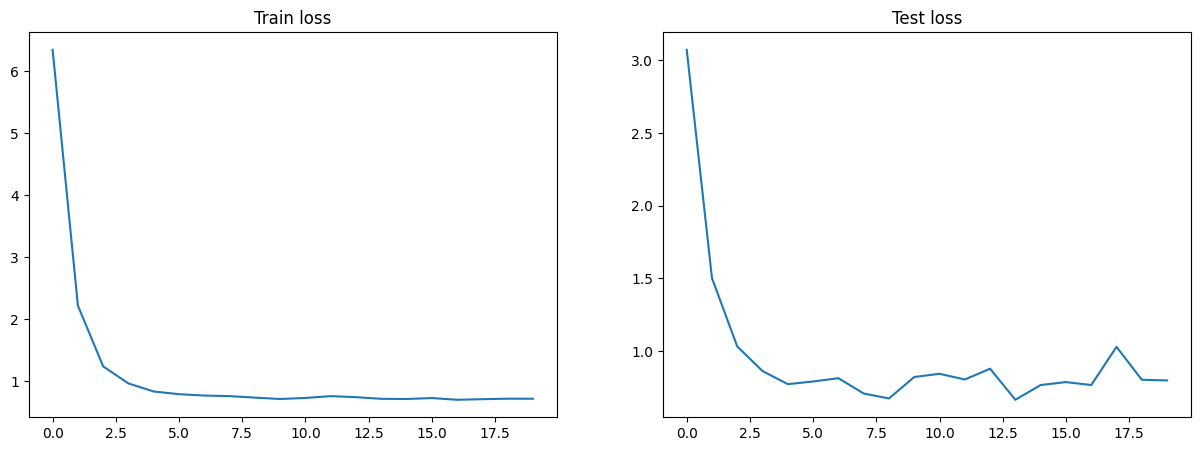

In [25]:
plot_history(history) # 3단계

### 8.2.4 모델을 활용한 결과 예측

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [27]:
predicted = model.predict(x_test)
y_pred = np.argmax(predicted, axis=1)
Y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
report = classification_report(Y_test, y_pred)

2/2 [==============================] - 9s 62ms/step


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

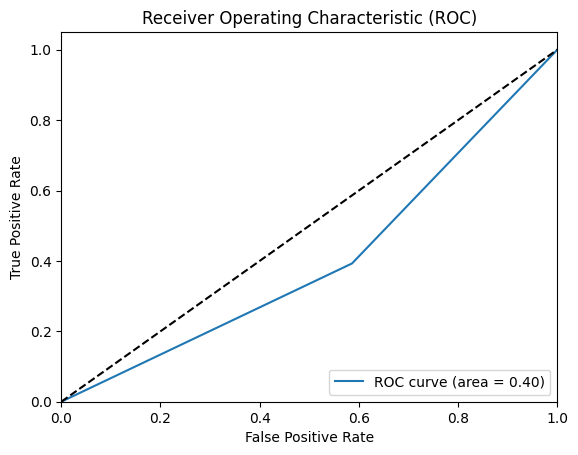

ROC AUC 값 : 0.4033


In [29]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

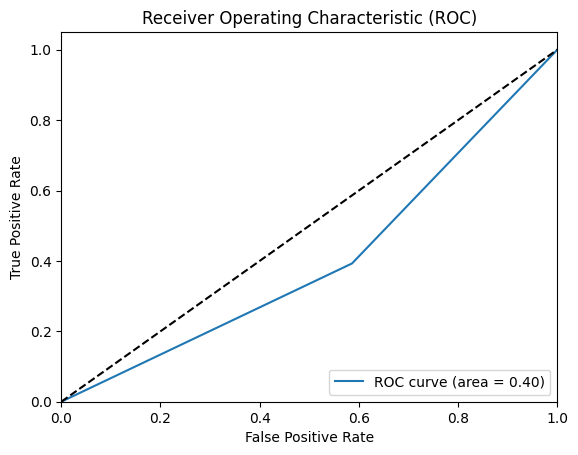

ROC AUC 값 : 0.4033


In [30]:
# 3단계
plot_roc(y_pred,Y_test)
from sklearn.metrics import roc_auc_score
roc_score = roc_auc_score(Y_test,y_pred)
print('ROC AUC 값 : {0:.4f}'.format(roc_score))

In [31]:
tn = cm[0][0]
fn = cm[1][0]
tp = cm[1][1]
fp = cm[0][1]
if tp == 0:
    tp = 1
if tn == 0:
    tn = 1
if fp == 0:
    fp = 1
if fn == 0:
    fn = 1
TPR = float(tp)/(float(tp)+float(fn))
FPR = float(fp)/(float(fp)+float(tn))
accuracy = round((float(tp) + float(tn))/(float(tp) +
                                          float(fp) + float(fn) + float(tn)), 3)
specitivity = round(float(tn)/(float(tn) + float(fp)), 3)
sensitivity = round(float(tp)/(float(tp) + float(fn)), 3)
mcc = round((float(tp)*float(tn) - float(fp)*float(fn))/math.sqrt(
    (float(tp)+float(fp))
    * (float(tp)+float(fn))
    * (float(tn)+float(fp))
    * (float(tn)+float(fn))
), 3)

f_output = open('binary_lstm_open_close_phase3_dropout_batch_Normal_3단계 test.txt', 'a')
f_output.write('=======\n')
f_output.write('{}epochs_{}batch\n'.format(
    20, 10))
f_output.write('TN: {}\n'.format(tn))
f_output.write('FN: {}\n'.format(fn))
f_output.write('TP: {}\n'.format(tp))
f_output.write('FP: {}\n'.format(fp))
f_output.write('TPR: {}\n'.format(TPR))
f_output.write('FPR: {}\n'.format(FPR))
f_output.write('accuracy: {}\n'.format(accuracy))
f_output.write('specitivity: {}\n'.format(specitivity))
f_output.write("sensitivity : {}\n".format(sensitivity))
f_output.write("mcc : {}\n".format(mcc))
f_output.write("{}".format(report))
f_output.write('=======\n')
f_output.close()

<Axes: xlabel='Date'>

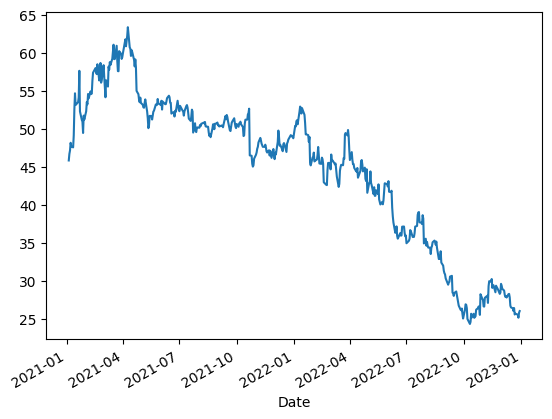

In [32]:
train_sample_df['Adj Close'].plot()

<Axes: xlabel='Date'>

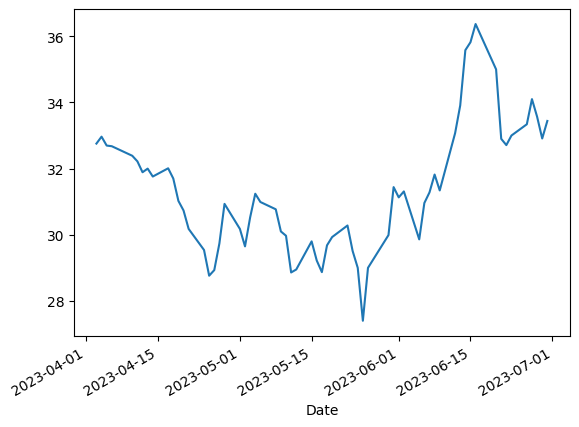

In [33]:
test_sample_df['Adj Close'].plot()

In [34]:
# 3단계
lstm_book_df = test_sample_df[['Adj Close','next_rtn']].copy()
# ### 이 문제에 있어서 Series와 DataFrame의 차이는 뭐지?
t1 = pd.DataFrame(data = y_pred,columns=['position'],index = lstm_book_df.index[5:])
lstm_book_df = lstm_book_df.join(t1,how='left')
lstm_book_df.fillna(0,inplace=True)
lstm_book_df['ret'] = lstm_book_df['Adj Close'].pct_change()
lstm_book_df['lstm_ret'] = lstm_book_df['next_rtn'] * lstm_book_df['position'].shift(1)
lstm_book_df['lstm_cumret'] = (lstm_book_df['lstm_ret'] + 1).cumprod()
lstm_book_df['bm_cumret'] = (lstm_book_df['ret'] + 1).cumprod()

<Axes: xlabel='Date'>

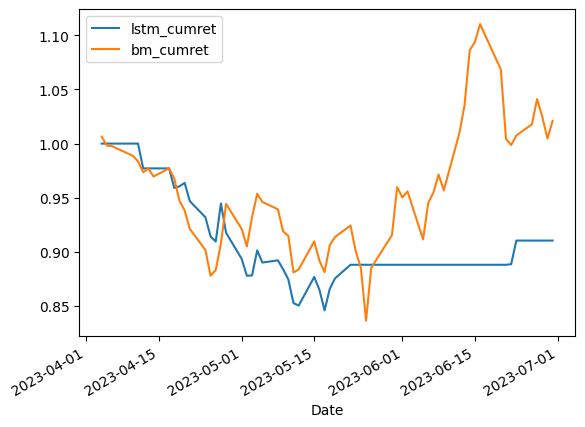

In [35]:
lstm_book_df[['lstm_cumret','bm_cumret']].plot()

<Axes: xlabel='Date'>

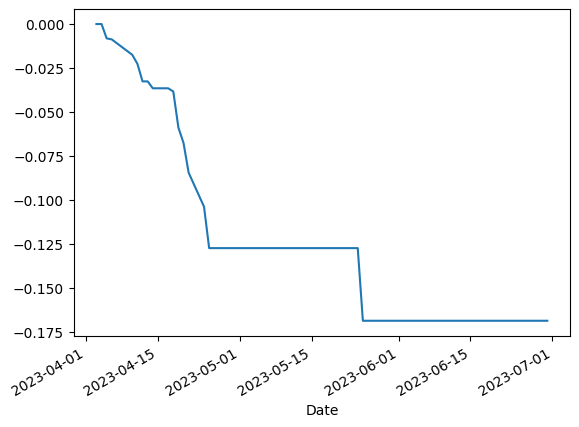

In [36]:
historical_max = lstm_book_df['Adj Close'].cummax()
daily_drawdown = lstm_book_df['Adj Close'] / historical_max - 1.0
historical_dd = daily_drawdown.cummin()
historical_dd.plot()

In [37]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'bm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['ret']) / np.std(lstm_book_df['ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  8.76 %
Sharpe :  0.41
VOL :  40.58 %
MDD :  16.88 %


In [38]:
CAGR = lstm_book_df.loc[lstm_book_df.index[-1],'lstm_cumret'] ** (252./len(lstm_book_df.index)) -1
Sharpe = np.mean(lstm_book_df['lstm_ret']) / np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
VOL = np.std(lstm_book_df['lstm_ret']) * np.sqrt(252.)
MDD = historical_dd.min()
print('CAGR : ',round(CAGR*100,2),'%')
print('Sharpe : ',round(Sharpe,2))
print('VOL : ',round(VOL*100,2),'%')
print('MDD : ',round(-1*MDD*100,2),'%')

CAGR :  -31.69 %
Sharpe :  -1.82
VOL :  20.11 %
MDD :  16.88 %


### 8.2.5 요약